# Spatial relationships and operations
based on scipy2018-geospatial

## goals of the tutorial
- spatial projection conversion
- spatial relationships 
- spatial joins
- spatial operations

**based on the open data of:**
- [ISTAT](https://www.istat.it/it/archivio/222527) Italian National Institute of Statistic 
- [MIBACT](https://anagrafe.iccu.sbn.it/it/open-data/) Italian Ministery of Cultural Heritage


### requirements
- python knowledge
- pandas

### status 
*"Spatial is Special"*

---

# SETUP

## We need a OS with the rtree index
needed for geopandas spatial relationships

In [ ]:
try:
  import rtree
except ModuleNotFoundError as e:
  !apt-get install libspatialindex-dev
  !pip install rtree
  import rtree

In [ ]:
!pip install geopandas

     |████████████████████████████████| 972kB 2.9MB/s 
     |████████████████████████████████| 10.9MB 17.0MB/s 
     |████████████████████████████████| 14.8MB 316kB/s 


In [ ]:
# special issue: investigate the data with pandas profile!!!
!pip install -U pandas-profiling
import pandas_profiling 

     |████████████████████████████████| 266kB 2.9MB/s 
     |████████████████████████████████| 71kB 6.2MB/s 
     |████████████████████████████████| 71kB 5.8MB/s 
     |████████████████████████████████| 604kB 7.3MB/s 
     |████████████████████████████████| 3.1MB 14.2MB/s 
     |████████████████████████████████| 71kB 8.4MB/s 
     |████████████████████████████████| 296kB 19.5MB/s 
  Created wheel for htmlmin: filename=htmlmin-0.1.12-cp36-none-any.whl size=27085 sha256=4d267b821655f924ffc5a685e5e48161a17a3e190862be2134d4cc1e5301bc1d
  Stored in directory: /root/.cache/pip/wheels/43/07/ac/7c5a9d708d65247ac1f94066cf1db075540b85716c30255459
  Created wheel for imagehash: filename=ImageHash-4.1.0-py2.py3-none-any.whl size=291991 sha256=66fd50793c98b186afe09ae73317c7ef6c5a8bd9e9c3042ca0fb7559f133d902
  Stored in directory: /root/.cache/pip/wheels/07/1c/dc/6831446f09feb8cc199ec73a0f2f0703253f6ae013a22f4be9
Successfully built htmlmin imagehash
  Found existing installation: tqdm 4.41.1
    Uni

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
import os
import pandas as pd
import geopandas as gpd
import requests, zipfile, io

## data setup
based on the previous tutorial

In [ ]:
if not os.path.exists('Limiti01012020'):
    # download the data
    zip_file_url = 'http://www.istat.it/storage/cartografia/confini_amministrativi/generalizzati/Limiti01012020.zip'
    #request the file
    r = requests.get(zip_file_url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    #unzip the file
    z.extractall()
    # read the file
macroregions=gpd.read_file('Limiti01012020' + os.sep + 'RipGeo01012020' + os.sep + 'RipGeo01012020_WGS84.shp')

# Investigate the dataset of the italian public libraries
## from a dataframe to a geodataframe

we have a csv file with some point of interest where the coordinates are expressed in a column for the longitude and another for the latitude.

### the dataset of the public libraries
The italian Ministery of Cultural Heritage offers the open data with the location of public libraries in Italy
https://anagrafe.iccu.sbn.it/it/open-data/

here the link for the [download](http://opendata.anagrafe.iccu.sbn.it/territorio.zip)


This dataset is NOT archived in a spatial format.

**load the data with pandas**


In [ ]:
libraries = pd.read_csv('http://opendata.anagrafe.iccu.sbn.it/territorio.zip', compression='zip', sep=';')

In [ ]:
libraries.profile_report()

In [ ]:
libraries.shape

(11715, 17)

In [ ]:
libraries.head(5)

codice-isil  ...                                                url
0   IT-AG0001  ...                                                NaN
1   IT-AG0005  ...  http://www.archiviodistatoagrigento.benicultur...
2   IT-AG0006  ...                                                NaN
3   IT-AG0007  ...  http://www.opacagrigento.it/biblioteche/bi_1.html
4   IT-AG0008  ...                                                NaN

[5 rows x 17 columns]

In [ ]:
libraries.columns

Index(['codice-isil', 'codice-sbn', 'denominazione', 'indirizzo', 'frazione',
       'cap', 'comune', 'codice istat comune', 'provincia', 'regione',
       'codice istat provincia', 'latitudine', 'longitudine', 'telefono',
       'fax', 'email', 'url'],
      dtype='object')

we can use the columns *latitudine* and *longitudine* to plot a map

note:<br>
the **separator** of the decimal is with the **comma** and not with the **dot**.<br/>
We need to change it!

In [ ]:
libraries.latitudine = pd.to_numeric(libraries.latitudine.str.replace(",","."))
libraries.longitudine = pd.to_numeric(libraries.longitudine.str.replace(",","."))

We also to check the presence of NULL values

In [ ]:
libraries.latitudine.isnull().values.sum()

74

we can't work with the rows with NULL values

In [ ]:
libraries = libraries[libraries.latitudine.isnull() == False]

now we are ready to create the geodataframe.
the operation are:
- creation of a geometry column based on the WKT syntax
- transform the DataFrame in GeoDataFrame

In [ ]:
# we need shapely to create the Point geometry
from shapely.geometry import Point

In [ ]:
libraries = gpd.GeoDataFrame(
    libraries.drop(['longitudine', 'latitudine'], axis=1),
    crs={'init': 'epsg:4326'},
    geometry=[Point(xy) for xy in zip(libraries.longitudine, libraries.latitudine)])

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


... and now we can plot the map!!!

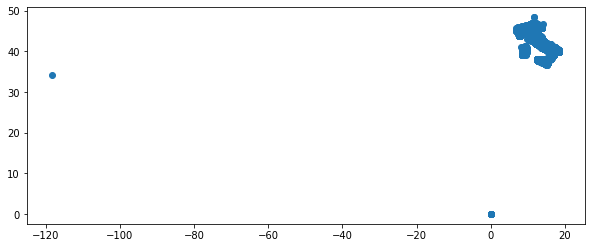

In [ ]:
libraries.plot(figsize=(10,10))

there are some **mistakes**!!!

we plot the dots over the macro-regions of Italy

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


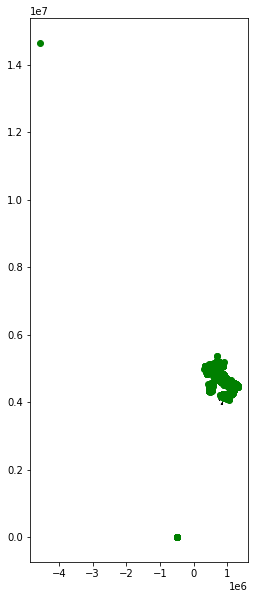

In [ ]:
ax = macroregions.plot(edgecolor='k', facecolor='none', figsize=(15, 10))
libraries.to_crs({'init': 'epsg:32632'}).plot(ax=ax,color="green")

## identify the boundary of the two datasets
#### calculate  the bounds

In [ ]:
italy_bounds = macroregions.to_crs({'init': 'epsg:4326'}).bounds

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [ ]:
italy_bounds

minx       miny       maxx       maxy
0   6.626621  43.775663  11.427673  46.635187
1   9.197912  43.731892  13.918853  47.091784
2   9.686700  40.784734  14.027645  44.472707
3  13.018488  37.915754  18.520382  42.895081
4   8.130728  35.492853  15.652935  41.313321

**italy**<br/>
coordinates of the boundary: low left point and top right point

In [ ]:
print(italy_bounds.minx.min(),italy_bounds.miny.min(),italy_bounds.maxx.max(),italy_bounds.maxy.max())

6.626621368537681 35.492852601228584 18.520381599098922 47.09178374646217


**libraries**

In [ ]:
print(libraries.bounds.minx.min(),libraries.bounds.miny.min(),libraries.bounds.maxx.max(),libraries.bounds.maxy.max())

-118.241653 0.0 18.491521 48.426567


*data and map show us that the boundaries are not equals!*

---
# Spatial relationships 
## how two spatial objects relate to each other 

![](https://upload.wikimedia.org/wikipedia/commons/5/55/TopologicSpatialRelarions2.png)

from [https://en.wikipedia.org/wiki/Spatial_relation](https://en.wikipedia.org/wiki/Spatial_relation)

## Relationships between individual objects

Eg.<br>
Is this library located in the north-west Italian macro-region?

we need the north-west italian macro-region in wgs84

In [ ]:
northwest = macroregions.to_crs({'init': 'epsg:4326'})[macroregions.COD_RIP==1].geometry[0]

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [ ]:
northwest

we choose a libraries in Torino (north west italy)

In [ ]:
libraries[libraries.comune == 'Torino'].head(1)

codice-isil  ...                  geometry
10061   IT-TO0071  ...  POINT (7.65028 45.03513)

[1 rows x 16 columns]

In [ ]:
alibraryinturin = libraries[libraries['codice-sbn'] == 'TO0D8'].reindex().geometry.values[0]

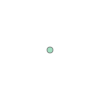

In [ ]:
alibraryinturin

## within relation
in our case:<br>&nbsp;&nbsp;&nbsp;&nbsp;it's the point inside the area?

In [ ]:
alibraryinturin.within(northwest)

True

## contain relation
in our case:<br>&nbsp;&nbsp;&nbsp;&nbsp;does the area contain the point?

In [ ]:
northwest.contains(alibraryinturin)

True

we can iterate the operation for each point

_very slow!_

In [ ]:
%%time
libraries_northwest = libraries[libraries.within(northwest)]

CPU times: user 55.9 s, sys: 86.5 ms, total: 56 s
Wall time: 56 s


In [ ]:
libraries_northwest.shape

(3258, 16)

<div class="alert alert-info" style="font-size:120%">
<b>REFERENCE</b>: <br>

Overview of the different functions to check spatial relationships (*spatial predicate functions*):
<ul>
    <li>`equals`</li>
<li>`contains`</li>
<li>`crosses`</li>
<li>`disjoint`</li>
<li>`intersects`</li>
<li>`overlaps`</li>
<li>`touches`</li>
<li>`within`</li>
<li>`covers`</li>
</ul>


See https://shapely.readthedocs.io/en/stable/manual.html#predicates-and-relationships for an overview of those methods.


See https://en.wikipedia.org/wiki/DE-9IM for all details on the semantics of those operations. 

# Spatial Joins

You can create a join like the usual [join](https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html) between pandas dataframe by using a spatial relationship with the function [geopandas.sjoin](http://geopandas.readthedocs.io/en/latest/reference/geopandas.sjoin.html)

In [ ]:
%%time
libraries_and_macroregions = gpd.sjoin(macroregions.to_crs({'init': 'epsg:4326'}), 
                          libraries, how='inner', op='contains', lsuffix='left', rsuffix='right')


/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


CPU times: user 1.99 s, sys: 15.6 ms, total: 2.01 s
Wall time: 2.02 s


In [ ]:
libraries_and_macroregions.columns

Index(['COD_RIP', 'DEN_RIP', 'SHAPE_AREA', 'SHAPE_LEN', 'geometry',
       'index_right', 'codice-isil', 'codice-sbn', 'denominazione',
       'indirizzo', 'frazione', 'cap', 'comune', 'codice istat comune',
       'provincia', 'regione', 'codice istat provincia', 'telefono', 'fax',
       'email', 'url'],
      dtype='object')

In [ ]:
libraries_and_macroregions.head(5)

COD_RIP  ...                                                url
0        1  ...                                                NaN
0        1  ...  https://opac.provincia.brescia.it/library/bibl...
0        1  ...                                                NaN
0        1  ...  http://www.comune.niardo.bs.it/pages/amministr...
0        1  ...  http://opac.provincia.brescia.it/library/bibli...

[5 rows x 21 columns]

... and now you can investigate the new geodataframe

In [ ]:
total_libraries_for_macroregion = libraries_and_macroregions.groupby(['DEN_RIP']).size().to_frame('size').reset_index().sort_values(['size', 'DEN_RIP'], ascending=False)

In [ ]:
total_libraries_for_macroregion.rename(columns={'size':'total','DEN_RIP':'macroregion'},inplace=True)

In [ ]:
total_libraries_for_macroregion.set_index('macroregion',inplace=True)

In [ ]:
total_libraries_for_macroregion

total
macroregion       
Nord-Ovest    3258
Nord-Est      2803
Centro        2329
Sud           2070
Isole         1110

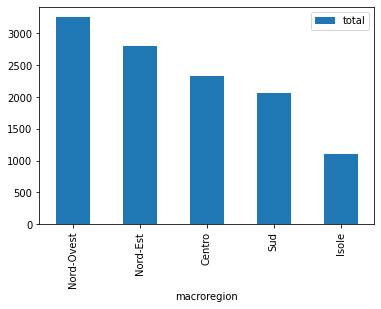

In [ ]:
total_libraries_for_macroregion.plot.bar()


<div class="alert alert-info" style="font-size:120%">
<b>SPATIAL JOIN </b>= *transferring attributes from one layer to another based on their spatial relationship*<br/>

Different parts of this operations:
<ul>
    <li>The GeoDataFrame to which we want add information</li>
    <li>The GeoDataFrame that contains the information we want to add</li>
    <li>The spatial relationship we want to use to match both datasets ('intersects', 'contains', 'within')</li>
    <li>The type of join: left or inner join</li>
</ul>


---
# Spatial operations 
GeoPandas provide analysis methods that return new geometric objects (based on shapely)

See https://shapely.readthedocs.io/en/stable/manual.html#spatial-analysis-methods for more details.

## Es. buffer
*object.buffer(distance, resolution=16, cap_style=1, join_style=1, mitre_limit=5.0)*

    Returns an approximate representation of all points within a given distance of the this geometric object.

In [ ]:
alibraryinturin_32632 = libraries.to_crs(epsg=32632)[libraries['codice-sbn'] == 'TO0D8'].reindex().geometry.values[0]

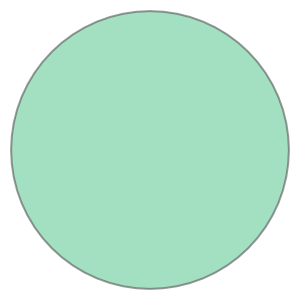

In [ ]:
alibraryinturin_32632.buffer(9000) # a circle with a ray of 9000 meters

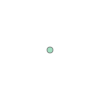

In [ ]:
alibraryinturin_32632

## Es. simplify

*object.simplify(tolerance, preserve_topology=True)*

    Returns a simplified representation of the geometric object.


In [ ]:
northwest_32632 = macroregions[macroregions.COD_RIP==1].geometry[0]

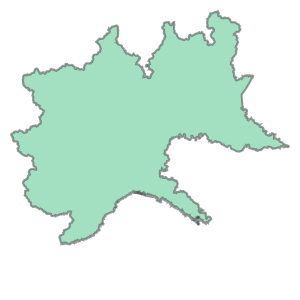

In [ ]:
northwest_32632

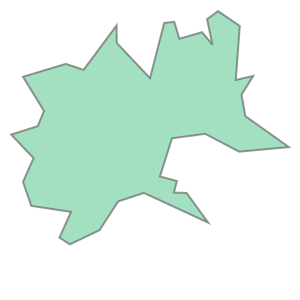

In [ ]:
northwest_32632.simplify(10000,preserve_topology=False)

## Es. symmetric_difference
*object.symmetric_difference(other)*

    Returns a representation of the points in this object not in the other geometric object, and the points in the other not in this geometric object.


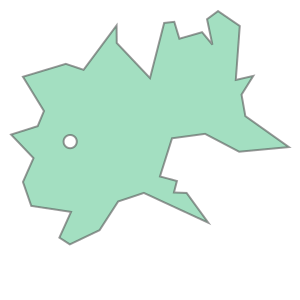

In [ ]:
northwest_32632.simplify(10000,preserve_topology=False).symmetric_difference(alibraryinturin_32632.buffer(9000))

<div class="alert alert-info" style="font-size:120%">
<b>REMEMBER:</b>

GeoPandas (and Shapely for the individual objects) provides a whole lot of basic methods to analyse the geospatial data (distance, length, centroid, boundary, convex_hull, simplify, transform, ....), much more than the few that we can touch in this tutorial.
<ul>
<li>An overview of all methods provided by GeoPandas can be found here: <a href="http://geopandas.readthedocs.io/en/latest/reference.html">http://geopandas.readthedocs.io/en/latest/reference.html</a></li>
    </ul>



---
# Aggregation with dissolve

Spatial data are often more granular than we need. For example, we have the data of the macro-regions but we don't have a geometry with the border of Italy.

If we have a columns to operate a *groupby* we can solve it but to create the geometry we need the function *dissolve*.



In [ ]:
macroregions['nation']='italy'

In [ ]:
italy = macroregions[['nation', 'geometry']]

In [ ]:
italy = italy.to_crs({'init': 'epsg:4326'}).dissolve(by='nation')
%time

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


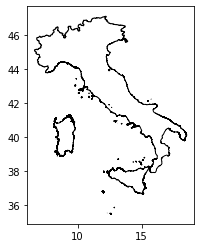

In [ ]:
italy.plot(facecolor="none", edgecolor='black')

<div class="alert alert-info" style="font-size:120%">
<b>REMEMBER:</b>

dissolve can be thought of as doing three things: (a) it **dissolves** all the geometries within a given group together into a single geometric feature (using the *unary_union* method), and (b) it **aggregates** all the rows of data in a group using *groupby.aggregate()*, and (c) it **combines** those two results.
    
<ul>
<li>An overview of all methods provided by GeoPandas can be found here: <a href="http://geopandas.org/aggregation_with_dissolve.html">http://geopandas.org/aggregation_with_dissolve.html</a></li>
 </ul>

---
# Exercise
- clean the dataset of the italian libraries with the points outside a region
- filter, by using a spatial relationship, all the libraries of an italian municipality
- choose a library in Bolzano and a library in Siracusa and calculate the geodentic distance in meters<br/>suggestion: *.distance(other)*
---